Notebook purpose

- Develop analysis code

In [1]:
import contextlib
import math
import os
import re
import sys

import linearmodels as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.analysis.helpers as ah
import entropy.analysis.make_analysis_data as ad
import entropy.analysis.sumstats_table as ss
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as ff
import entropy.figures.helpers as fh
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [6]:
import warnings

warnings.filterwarnings("once")

## Data description

**Read transactions data**

In [7]:
dft = hd.read_sample("777")
hd.inspect(dft)

Time for read_sample                   : 1.95 seconds
(92,989, 28)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_registration_date,account_created,account_id,account_last_refreshed,account_provider,account_type,debit,female,latest_balance,merchant_business_line,postcode,tag_auto,tag_manual,tag_up,ym,yob,income,age,entropy_sptac,region
0,2981363,2012-11-01,7777,-800.00,<mdbremoved> bac,NaN,NaN,NaN,2012-10-27,2013-01-06,151112,2020-03-11 16:27:00,natwest bank,current,False,0.0,3110.219971,NaN,gu14 9,NaN,NaN,NaN,201211,1983.0,27100.681641,29.0,2.846618,South East
1,2981500,2012-11-01,7777,11.98,forces financial - d/d,forces financial,spend,finance,2012-10-27,2013-01-06,151110,2020-03-11 16:27:00,natwest bank,current,True,0.0,22128.669922,forces financial,gu14 9,insurance,home insurance,home insurance,201211,1983.0,27100.681641,29.0,2.846618,South East


**Read analysis data**

In [8]:
df = hd.read_analysis_data()
df

Time for read_analysis_data            : 1.72 seconds


txn_count_sa  txn_count_ca   sa_inflows  sa_outflows  \
user_id date                                                               
37      2012-02-29           3.0           8.0  3340.000000       1740.0   
        2012-03-31           2.0           9.0     0.000000          0.0   
        2012-04-30           1.0           9.0     0.000000       1500.0   
        2012-05-31           1.0          13.0  2848.500000          0.0   
        2012-06-30           0.0          11.0     0.000000          0.0   
...                          ...           ...          ...          ...   
589517  2020-03-31          14.0         166.0   656.099976       1200.0   
        2020-04-30           9.0         125.0   541.280029          0.0   
        2020-05-31           9.0         132.0   541.280029          0.0   
        2020-06-30          16.0         196.0   656.099976        200.0   
        2020-07-31          12.0         165.0   541.280029        350.0   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
37      2012-02-29     1600.000000           2.135478            1.112494   
        2012-03-31        0.000000           0.000000            0.000000   
        2012-04-30    -1500.000000           0.000000            0.959047   
        2012-05-31     2848.500000           1.821230            0.000000   
        2012-06-30        0.000000           0.000000            0.000000   
...                            ...                ...                 ...   
589517  2020-03-31     -543.900024           0.290081            0.530554   
        2020-04-30      541.280029           0.239315            0.000000   
        2020-05-31      541.280029           0.239315            0.000000   
        2020-06-30      456.099976           0.290081            0.088426   
        2020-07-31      191.280029           0.239315            0.154745   

                    sa_scaled_net_inflows  monthly_spend  log_monthly_spend  \
user_id date                                                                  
37      2012-02-29               1.022983     528.239990           6.269551   
        2012-03-31               0.000000     429.880005           6.063506   
        2012-04-30              -0.959047    1208.160034           7.096854   
        2012-05-31               1.821230     624.010010           6.436166   
        2012-06-30               0.000000     723.869995           6.584612   
...                                   ...            ...                ...   
589517  2020-03-31              -0.240474    2709.879883           7.904660   
        2020-04-30               0.239315    2675.770020           7.891993   
        2020-05-31               0.239315    1970.469971           7.586027   
        2020-06-30               0.201655    2727.679932           7.911207   
        2020-07-31               0.084570    2508.889893           7.827596   

                    prop_spend_services  prop_spend_household  \
user_id date                                                    
37      2012-02-29             0.224898              0.591852   
        2012-03-31             0.028799              0.761841   
        2012-04-30             0.048553              0.435530   
        2012-05-31             0.039214              0.770805   
        2012-06-30             0.038087              0.585754   
...                                 ...                   ...   
589517  2020-03-31             0.129249              0.638615   
        2020-04-30             0.361417              0.497984   
        2020-05-31             0.196212              0.610560   
        2020-06-30             0.233572              0.557774   
        2020-07-31             0.226913              0.595052   

                    prop_spend_communication  prop_spend_other_spend  \
user_id date                                                           
37      201

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x165adea00>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


**Sample selection - see paper**

**Number of unique users**

In [27]:
df.index.get_level_values("user_id").nunique()

3103

**Number of months we observe users for**

count    3103.000000
mean       30.150500
std        17.273922
min         6.000000
25%        16.000000
50%        27.000000
75%        40.000000
max       102.000000
dtype: float64


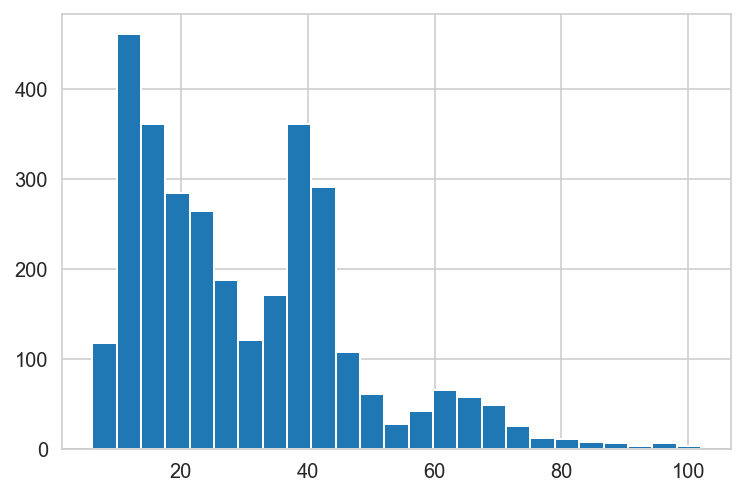

In [9]:
user_months = df.groupby("user_id").size()
print(user_months.describe())
user_months.hist(bins=25);

**User characteristics**

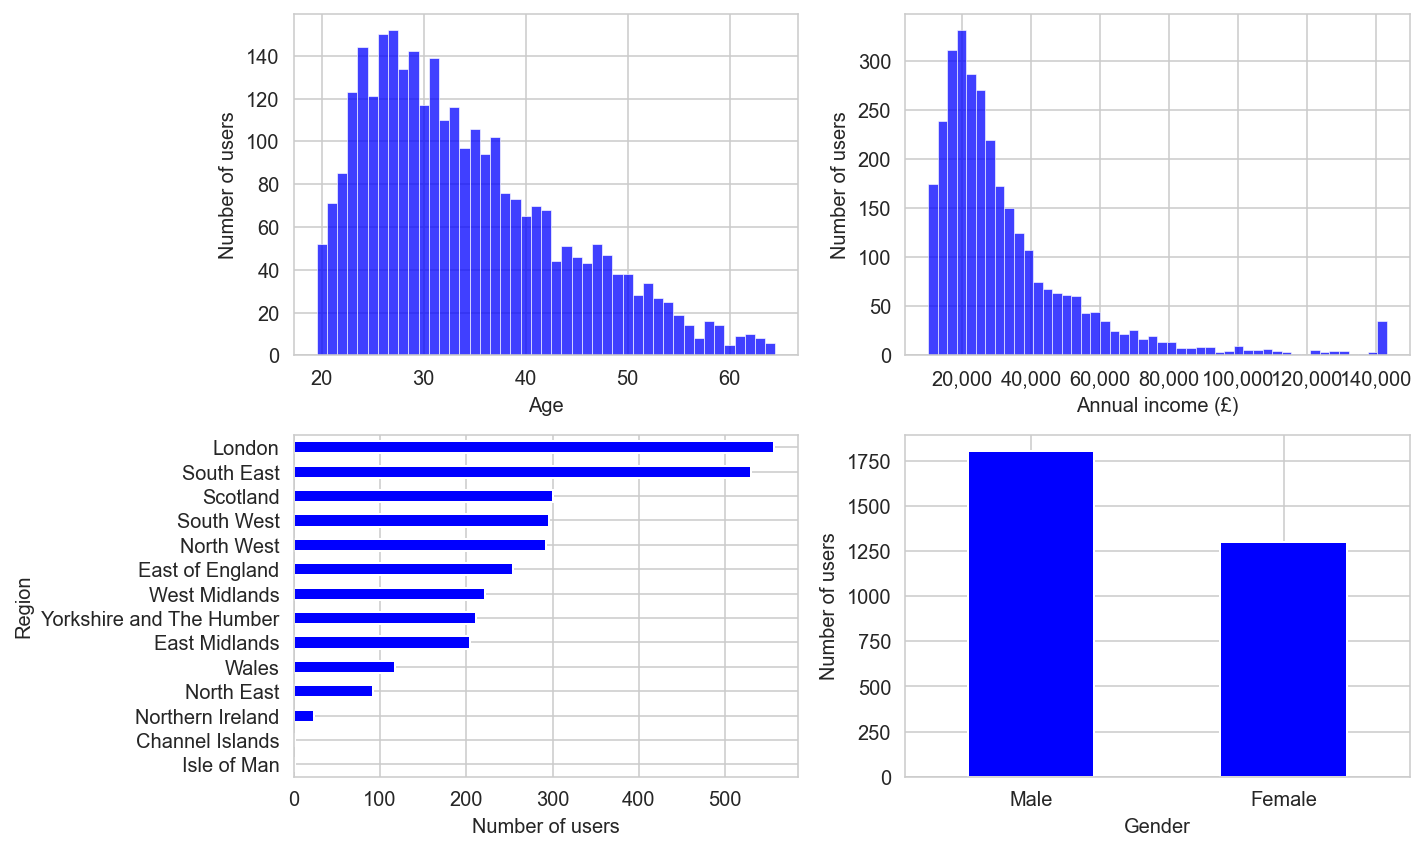

In [34]:
ff.user_chars(df, write=False)

**Summary statistics**

In [38]:
ss.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
txn_count_sa,93557.0,4.243798,8.519068,0.000000,3.890000e+02,0.000000,2.000000,5.000000
txn_count_ca,93557.0,92.854388,53.454898,2.000000,9.060000e+02,57.000000,82.000000,116.000000
sa_inflows,93557.0,1234.191284,24596.449219,0.000000,6.215068e+06,0.000000,5.440000,420.000000
sa_outflows,93557.0,1151.614502,18713.050781,0.000000,4.524177e+06,0.000000,0.000000,400.000000
sa_net_inflows,93557.0,82.576759,12216.861328,-705792.062500,1.690891e+06,0.000000,0.000000,70.000000
sa_scaled_inflows,93557.0,0.395806,4.463429,0.000000,6.456697e+02,0.000000,0.002437,0.180307
sa_scaled_outflows,93557.0,0.376805,3.267126,0.000000,3.875515e+02,0.000000,0.000000,0.171478
sa_scaled_net_inflows,93557.0,0.019000,4.716296,-387.468764,6.215899e+02,0.000000,0.000000,0.030515
monthly_spend,93557.0,2824.708008,5106.101074,200.529999,4.356753e+05,1174.839966,1885.040039,3164.840088
log_monthly_spend,93557.0,7.586336,0.767993,5.300964,1.298465e+01,7.068887,7.541704,8.059857


In [31]:
k = df.copy()

mmap = {0: 1, 1: 0}
k["male"] = k.female.map(mmap)
k = k[["income", "male", "female"]]

print(lm.PanelOLS.from_formula("income ~ male + female", data=k).fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                 income   R-squared:                        0.0090
Estimator:                   PanelOLS   R-squared (Between):              0.0080
No. Observations:               93557   R-squared (Within):               0.0000
Date:                Tue, Feb 01 2022   R-squared (Overall):              0.0090
Time:                        14:42:16   Log-likelihood                -1.144e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      847.66
Entities:                        3103   P-value                           0.0000
Avg Obs:                       30.150   Distribution:                 F(1,93555)
Min Obs:                       6.0000                                           
Max Obs:                       102.00   F-statistic (robust):          3.575e+04
                            

## Dependent variable - savings account inflows

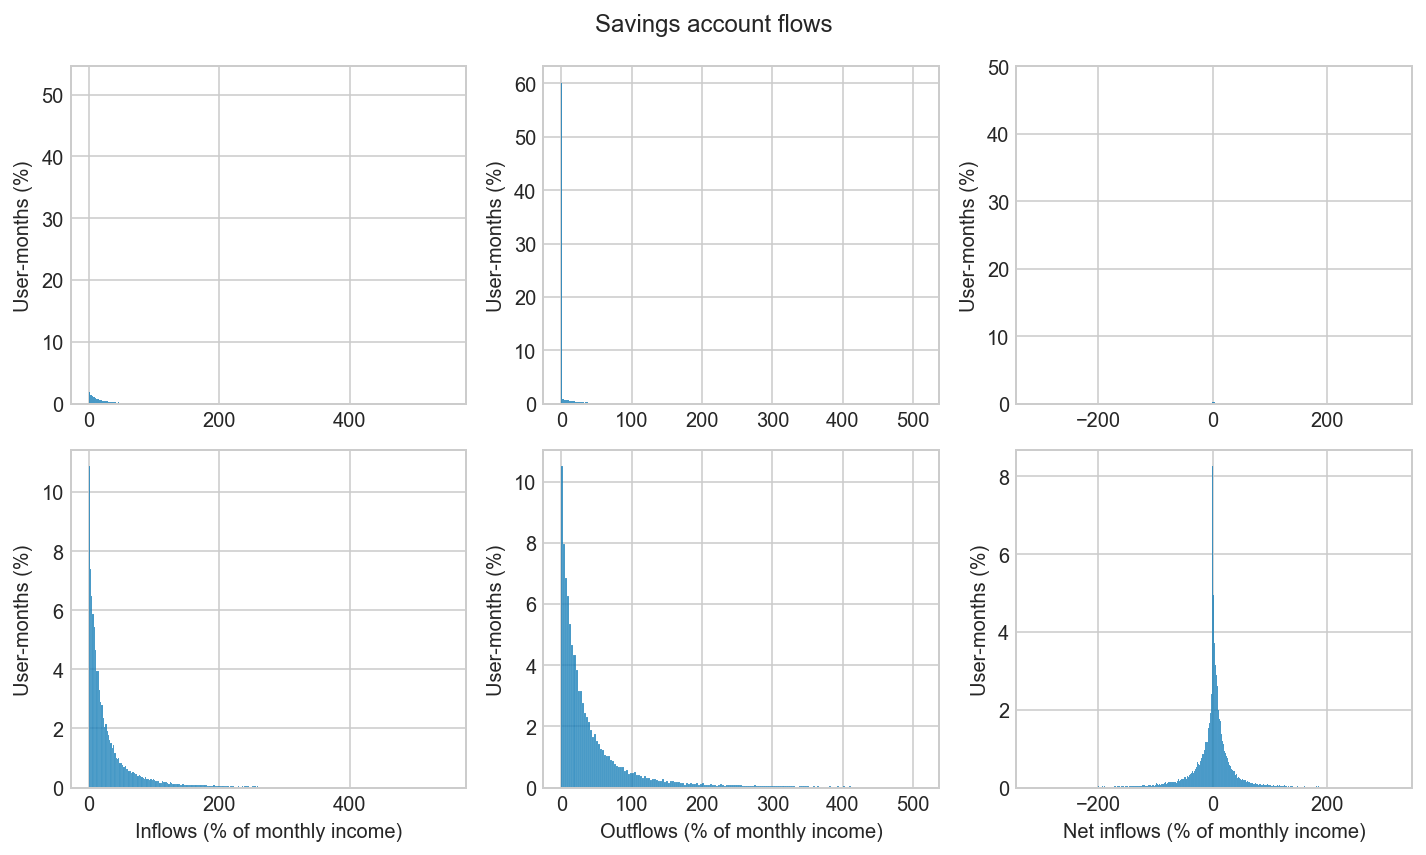

In [144]:
ff.sa_flows(df, write=False);

## Independent variable - entropy

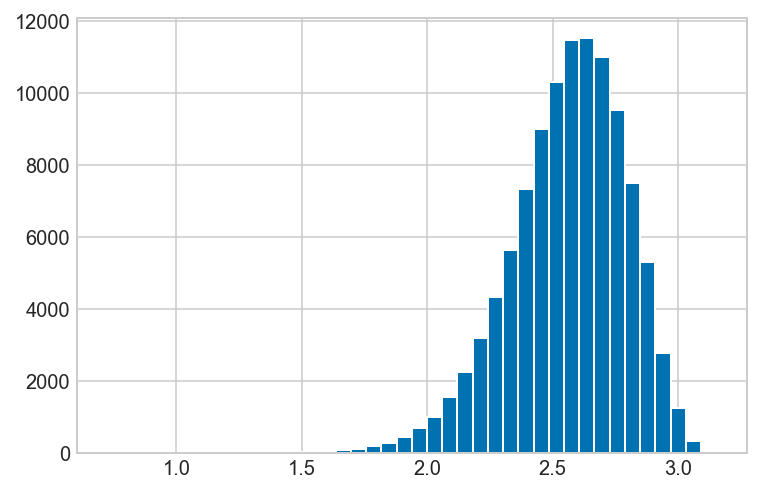

In [14]:
df.entropy_sptac.hist(bins=40);

Entropy calculation details

In [160]:
def user_month_entropy(df):
    def _calc_entropy(probs):
        return -sum(p * math.log2(p) for p in probs)

    return df.apply(_calc_entropy, axis=1)


# cr.entropy_spend_tag_counts_partial(dft)

## Correlations

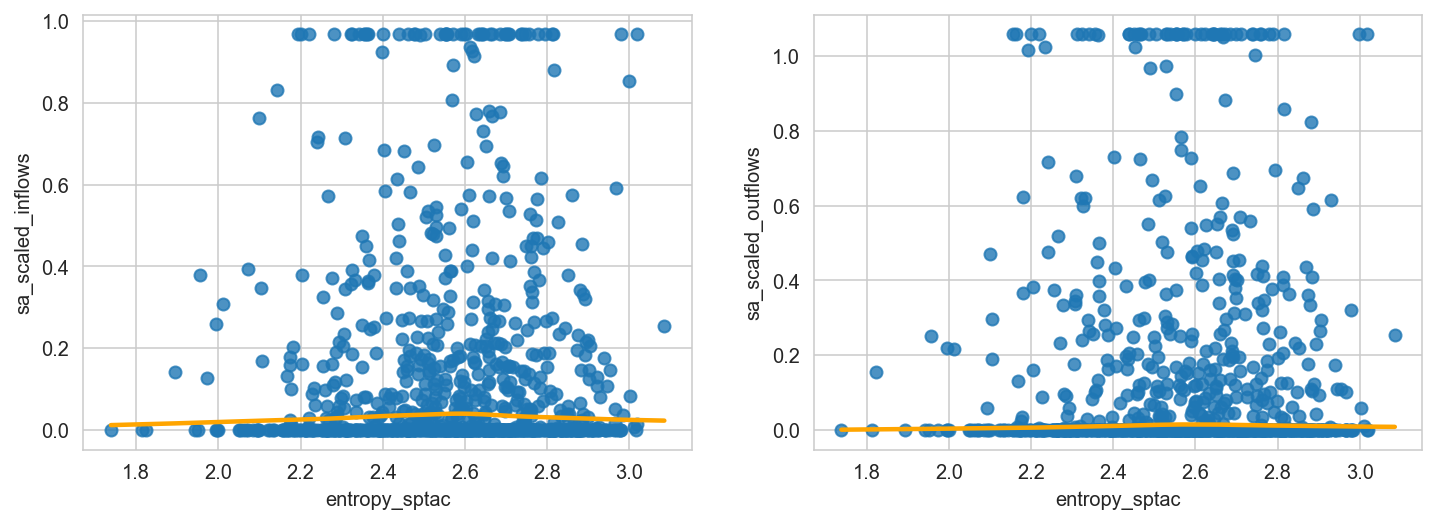

In [34]:
ff.regplot(df, y="sa_scaled_[io]", x="entropy", winsorise_kws=dict(pct=5, how="upper"))

## Main results

In [3]:
data = df

y = data["sa_scaled_inflows"]
prop_spends = list(data.filter(like="prop_spend").columns)
controls = ["log_monthly_spend"] + prop_spends
exog = data[["entropy_sptac"] + controls]

lm.panel.compare(
    [
        ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=True, time_effects=False),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=False),
    ],
    stars=True,
)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,93557,93557,93557,93557
Cov. Est.,Clustered,Clustered,Clustered,Clustered
R-squared,0.0016,0.0017,0.0035,0.0113
R-Squared (Within),0.0016,0.0017,0.0014,0.0014
R-Squared (Between),-1.597e+07,-2.081e+06,-1.573e+09,0.1095
R-Squared (Overall),-1.654e+06,-2.155e+05,-1.629e+08,0.0113
F-statistic,12.971,13.615,29.520,97.513
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


### Removing outliers

In [6]:
trim_pcts = [0, 1, 5, 10]

for trim_pct in trim_pcts:
    dd = df.copy()
    dd["sa_scaled_inflows"] = hd.trim(df.sa_scaled_inflows, pct=trim_pct, how="upper")

    data = dd
    y = data["sa_scaled_inflows"]
    prop_spends = list(data.filter(like="prop_spend").columns)
    controls = ["log_monthly_spend"] + prop_spends
    exog = data[["entropy_sptac"] + controls]

    print(f"Trim pct: {trim_pct}")
    print(
        lm.panel.compare(
            [
                ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
                ah.fe_reg(y, exog, entity_effects=True, time_effects=False),
                ah.fe_reg(y, exog, entity_effects=False, time_effects=True),
                ah.fe_reg(y, exog, entity_effects=False, time_effects=False),
            ],
            stars=True,
        )
    )

Trim pct: 0
                                                  Model Comparison                                                  
                                           Model 0               Model 1               Model 2               Model 3
--------------------------------------------------------------------------------------------------------------------
Dep. Variable                    sa_scaled_inflows     sa_scaled_inflows     sa_scaled_inflows     sa_scaled_inflows
Estimator                                 PanelOLS              PanelOLS              PanelOLS              PanelOLS
No. Observations                             93556                 93556                 93556                 93556
Cov. Est.                                Clustered             Clustered             Clustered             Clustered
R-squared                                   0.0019                0.0020                0.0041                0.0138
R-Squared (Within)                          0.0020  

### Possible explanations and next steps

- Check data integrity

- Entropy measure doesn't capture behaviour we want 

    - Calculate alternative entropy measures
    
    - Validate entropy measures by correlating them with other indicators of stress


- Model is misspecified

    - Take into account truncated distribution of outcome variable using Tobit model

## Further analysis

### Unscaled income flows

In [140]:
data = df

y = data["sa_inflows"]
prop_spend = list(data.filter(like="prop_spend").columns)
controls = ["log_monthly_spend", "log_income"] + prop_spend
exogenous = data[["entropy_sptac"] + controls]

lm.panel.compare(
    [
        ah.fe_reg(y, exogenous, entity_effects=True, time_effects=True),
        ah.fe_reg(y, exogenous, entity_effects=True, time_effects=False),
        ah.fe_reg(y, exogenous, entity_effects=False, time_effects=True),
        ah.fe_reg(y, exogenous, entity_effects=False, time_effects=False),
    ],
    stars=True,
)

,Model 0,Model 1,Model 2,Model 3
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,93557,93557,93557,93557
Cov. Est.,Clustered,Clustered,Clustered,Clustered
R-squared,0.0007,0.0007,0.0049,0.0076
R-Squared (Within),0.0007,0.0007,0.0003,0.0003
R-Squared (Between),-7.025e+06,-2.185e+06,-7.158e+09,0.0624
R-Squared (Overall),-1.41e+06,-4.388e+05,-1.437e+09,0.0076
F-statistic,5.2157,5.5482,38.613,59.400
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


### Individual controls

In [75]:
b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,9.548e-06,0.0005,0.0018,0.0002,0.0018,0.0018,0.0019,0.0040,0.0122
R-Squared (Within),9.284e-06,0.0005,0.0018,0.0003,0.0019,0.0019,0.0019,0.0017,0.0015
R-Squared (Between),-0.1107,-13.844,-3.5250,0.0934,-4.7574,-4.7574,-4.7990,-4.9851,0.1175
R-Squared (Overall),-0.0108,-1.3933,-0.3635,0.0090,-0.4885,-0.4885,-0.4926,-0.5107,0.0122
F-statistic,0.9901,28.384,92.464,2.8433,19.196,19.196,19.846,42.757,132.48
P-value (F-stat),0.3197,0.0000,0.0000,0.0024,0.0000,0.0000,0.0000,0.0000,0.0000


#### Pooled

In [71]:
full_controls = ["log_income", "age", "female", "log_monthly_spend"] + tag_spend

a = lm.PanelOLS(y, sm.add_constant(data["entropy_sptac"])).fit()
aa = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_income"]])).fit()
ab = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "age"]])).fit()
ac = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "female"]])).fit()
ad = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_monthly_spend"]])).fit()
ae = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + tag_spend[:-1]])).fit()
af = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit()
ag = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit(
    cov_type="clustered", cluster_entity=True
)


lm.panel.compare([a, aa, ab, ac, ad, ae, af, ag], stars=True)

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
R-Squared (Within),-4.12e-05,9.208e-05,-3.02e-05,-5.145e-05,0.0018,1.925e-05,0.0025,0.0025
R-Squared (Between),0.0006,0.0005,0.0193,0.0025,0.0252,0.0124,0.0618,0.0618
R-Squared (Overall),2.985e-05,9.394e-05,0.0014,0.0002,0.0037,0.0011,0.0069,0.0069
F-statistic,3.2024,5.0403,77.068,8.4124,197.00,12.888,52.893,52.893
P-value (F-stat),0.0735,0.0065,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000


### Total inflows

In [72]:
data = df
y = data["sa_inflows"]
tag_spend = list(df.filter(like="tag_spend").columns)
full_controls = ["log_income", "log_monthly_spend"] + tag_spend[:-1]

### Fixed effects

In [73]:
b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,107296,107296,107296,107296,107296,107296,107296,107296,107296
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,2.97e-06,3.711e-05,0.0009,8.9e-05,0.0009,0.0009,0.0009,0.0053,0.0075
R-Squared (Within),3.935e-06,4.764e-05,0.0009,9.283e-05,0.0009,0.0009,0.0009,0.0006,0.0002
R-Squared (Between),-0.0186,-0.1242,-0.8894,-0.0112,-1.2358,-1.2358,-1.2670,-7.5494,0.0558
R-Squared (Overall),-0.0035,-0.0277,-0.1835,-0.0021,-0.2537,-0.2537,-0.2600,-1.5241,0.0075
F-statistic,0.3080,1.9241,44.459,1.0255,8.5301,8.5301,8.9177,51.709,73.813
P-value (F-stat),0.5789,0.1460,0.0000,0.4164,0.0000,0.0000,0.0000,0.0000,0.0000


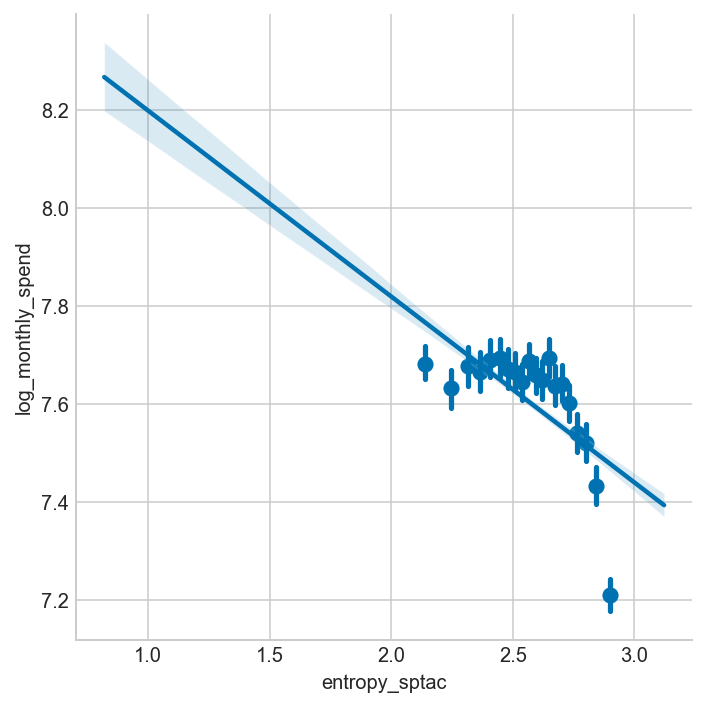

In [96]:
sns.lmplot(
    data=df.sample(frac=0.3), x="entropy_sptac", y="log_monthly_spend", x_bins=20
)